# Контекст
**Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.**

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt
from matplotlib import pyplot as plt
from IPython.display import display
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
orders = pd.read_csv('/datasets/orders.csv')
visitors =  pd.read_csv('/datasets/visitors.csv')

# Часть 1. Приоритизация гипотез.

In [3]:
hypothesis

Hypothesis  Reach  Impact  \
0  Добавить два новых канала привлечения трафика,...      3      10   
1  Запустить собственную службу доставки, что сок...      2       5   
2  Добавить блоки рекомендаций товаров на сайт ин...      8       3   
3  Изменить структура категорий, что увеличит кон...      8       3   
4  Изменить цвет фона главной страницы, чтобы уве...      3       1   
5  Добавить страницу отзывов клиентов о магазине,...      3       2   
6  Показать на главной странице баннеры с актуаль...      5       3   
7  Добавить форму подписки на все основные страни...     10       7   
8  Запустить акцию, дающую скидку на товар в день...      1       9   

   Confidence  Efforts  
0           8        6  
1           4       10  
2           7        3  
3           3        8  
4           1        1  
5           2        3  
6           8        3  
7           8        5  
8           9        5

In [4]:
hypothesis.columns = hypothesis.columns.str.lower()

In [5]:
hypothesis['ICE'] = round(hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts'] , 1)
hypothesis['RICE'] = hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']

In [6]:
pd.options.display.max_colwidth=150
display(hypothesis.sort_values(by = 'ICE' , ascending=False)[['hypothesis','ICE']])
display(hypothesis.sort_values(by = 'RICE' , ascending=False)[['hypothesis','RICE']])

hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
4                              Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   

    ICE  
8  16.2  
0  13.3  
7  11.2  
6   8.0  
2   7.0  
1   2.0  
5   1.3  
3   1.1  
4   1.0

hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
4                              Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей   

    RICE  
7  112.0  
2   56.0  
0   40.0  
6   40.0  
8   16.2  
3    9.0  
1    4.0  
5    4.0  
4    3.0

**Вывод**

Исходя из полученных таблиц можно увидеть что:

 - ICE лидируют гипотезы 8, 0, 7.
 - RICE 7, 2, 0.

Разница обусловливается тем, что при подсчете RICE мы так же учитываем сколько пользователей затронет изменение(Reach), поэтому 8 гипотеза в RICE попала на середину таблицы(Reach 8 гипотезы равен 1) хотя была лидером в таблице с ICE так же и другие гипотезы изменили своё положение именно из за появление этого фактора.

# Часть 2. Анализ A/B-теста

# 2.1 Подготовка данных для теста.

In [7]:
display(orders.head())
display(visitors.head())

transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     1650     B
1     2804400009  3642806036  2019-08-15      730     B
2     2961555356  4069496402  2019-08-15      400     A
3     3797467345  1196621759  2019-08-15     9759     B
4     2282983706  2322279887  2019-08-15     2308     B

date group  visitors
0  2019-08-01     A       719
1  2019-08-02     A       619
2  2019-08-03     A       507
3  2019-08-04     A       717
4  2019-08-05     A       756

In [8]:
display(orders.info())
display(visitors.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

In [9]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [10]:
print('Количетсво дубликатов в orders:', orders.duplicated().sum())
print('Количетсво дубликатов в visitors:',visitors.duplicated().sum())

Количетсво дубликатов в orders: 0
Количетсво дубликатов в visitors: 0


In [11]:
print('Количество пропусков у orders:')
print(orders.isna().sum())
print()
print('Количество пропусков у visitors:')
print(visitors.isna().sum())

Количество пропусков у orders:
transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Количество пропусков у visitors:
date        0
group       0
visitors    0
dtype: int64


**Так как в в две группы может попасть один клиент, уберем их из данных для корректность проведения теста.**

In [12]:
duplicate_id = ( 
    orders.groupby('visitorId', as_index=False) 
    .agg({'group': 'nunique'})    
)
list_duplicate_id = duplicate_id.query('group==2')['visitorId'].tolist()
print(list_duplicate_id)

orders = orders.query('visitorId not in @list_duplicate_id')

[8300375, 199603092, 232979603, 237748145, 276558944, 351125977, 393266494, 457167155, 471551937, 477780734, 818047933, 963407295, 1230306981, 1294878855, 1316129916, 1333886533, 1404934699, 1602967004, 1614305549, 1648269707, 1668030113, 1738359350, 1801183820, 1959144690, 2038680547, 2044997962, 2378935119, 2458001652, 2579882178, 2587333274, 2600415354, 2654030115, 2686716486, 2712142231, 2716752286, 2780786433, 2927087541, 2949041841, 2954449915, 3062433592, 3202540741, 3234906277, 3656415546, 3717692402, 3766097110, 3803269165, 3891541246, 3941795274, 3951559397, 3957174400, 3963646447, 3972127743, 3984495233, 4069496402, 4120364173, 4186807279, 4256040402, 4266935830]


In [13]:
print('Количество групп в тесте: ', orders['group'].nunique())
print()
print('Начало теста:', orders['date'].min()) 
print('Конец теста: ',   orders['date'].max())
print('Продолжительность теста' , (orders['date'].max() - orders['date'].min()))
print()
print('Количество пользователей в группе А:', orders[orders['group'] == 'A']['visitorId'].nunique())
print('Количество пользователей в группе B:',orders[orders['group'] == 'B']['visitorId'].nunique())

Количество групп в тесте:  2

Начало теста: 2019-08-01 00:00:00
Конец теста:  2019-08-31 00:00:00
Продолжительность теста 30 days 00:00:00

Количество пользователей в группе А: 445
Количество пользователей в группе B: 528


**Выводы**

 - Тест парный
 - Тест длился 30 дней
 - В группе А пользователей меньше чем в группе В

In [14]:
datesGroups = orders[['date','group']].drop_duplicates() 

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

date group  orders  buyers  revenue  visitors
0 2019-08-01     A      23      19   142779       719
1 2019-08-01     B      17      17    59758       713
2 2019-08-02     A      42      36   234381      1338
3 2019-08-02     B      40      39   221801      1294
4 2019-08-03     A      66      60   346854      1845

# 2.2 Построение графика кумулятивной выручки по группам.

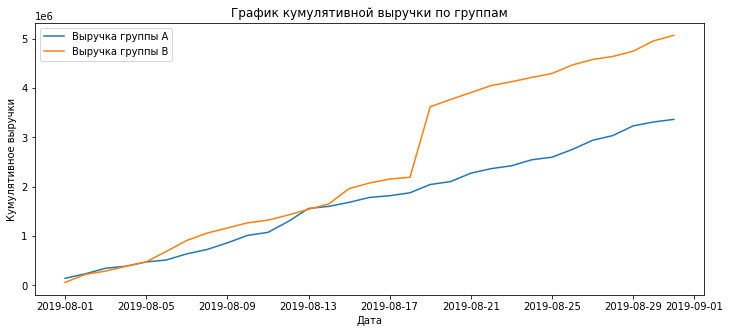

In [15]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(12,5))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='Выручка группы A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='Выручка группы B')

plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное выручки')
plt.legend()
plt.show()

**Вывод**

До 5 августа выручка шла равномерно, после выручка группы B стала расти, а в свою очередбь у группы A выручка падала, к 13 августу выручка двоих групп выравнилась, но 17 августа произошёл аномальный скачок в выручки группы B, что позволило ей вырваться вперед, после 17 августа выручка показывала стабильный рост без каких либо аномалий.

Из всего можно сделать вывод что 17 августа, у группы В произошло аномально много заказов либо же аномальная сумма заказа.

# 2.2 Построение графика кумулятивного среднего чека по группам.

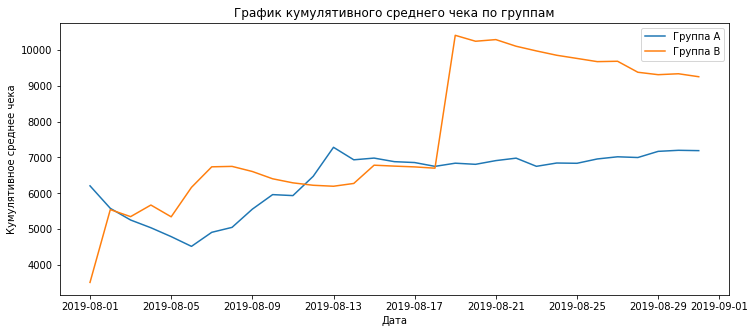

In [16]:
plt.figure(figsize=(12,5))

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='Группа A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='Группа B')

plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее чека')
plt.legend()
plt.show()

**Выводы**

Как в графике с выручкой наблюдаем, что до 17 августа кривые шли равномерно, было и снижение и рост , и к  17 числу они сравнялись, но 17 числа произошёл всплеск крупных заказов у группы В, после чего кривая у них стала снижаться и приходит в норму, у группы А средний чек после 17 августа устаканился.

# 2.3 График относительного изменения кумулятивного среднего чека группы B к группе A.

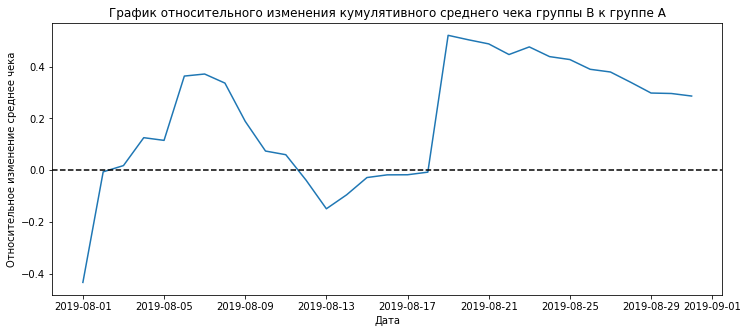

In [17]:
plt.figure(figsize=(12,5))
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднее чека')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

**Вывод**

На графике наблюдаем много резких скачков, поэтому определенные выводы из такого графики сделать сложно, в данных есть аномальные значения от которых нужно избавиться .

# 2.4 График кумулятивного среднего количества заказов на посетителя по группам.

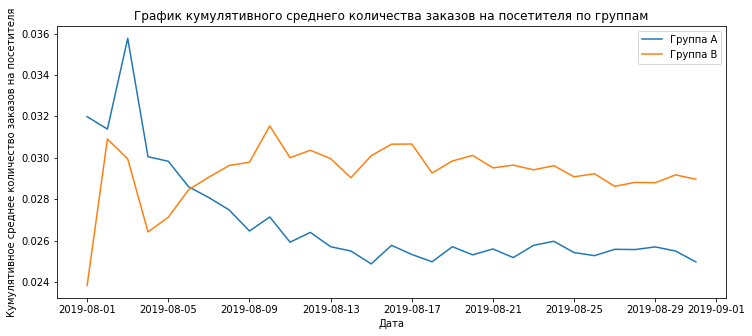

In [18]:
cumulativeData['average_number_of_orders'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12,5))

plt.plot(cumulativeDataA['date'], cumulativeDataA['average_number_of_orders'], label='Группа A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['average_number_of_orders'], label='Группа B')
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов на посетителя')
plt.legend()
plt.show()

**Выводы**

Как видно из графика в самом начале у группы А среднее кол-во заказов было много выше чем у группы В, но после 5 августа, заказы у группы А упали а у В выросли.В таком виде онии зафиксировались и можно смело сказать что у группы В среднее кол-во заказов больше.

# 2.5 График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A. 

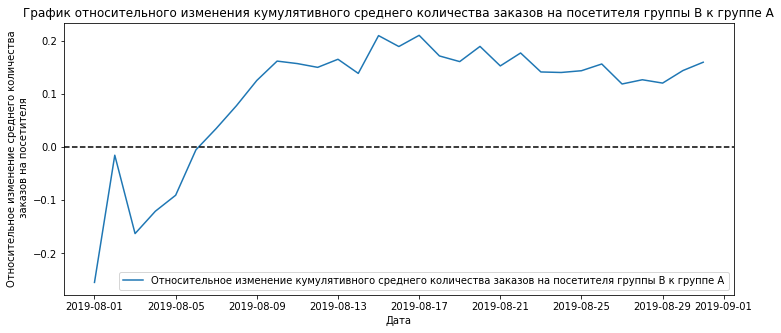

In [19]:
mergedCumulativeAvg = cumulativeDataA[['date','average_number_of_orders']].merge(cumulativeDataB[['date','average_number_of_orders']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(12,5))

plt.plot(mergedCumulativeAvg['date'], mergedCumulativeAvg['average_number_of_ordersB']/mergedCumulativeAvg['average_number_of_ordersA']-1, label="Относительное изменение кумулятивного среднего количества заказов на посетителя группы B к группе A")
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Относительное изменение среднего количества\n заказов на посетителя')
plt.legend()
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

**Выводы**

В начале теста группа В проигрывала, но после 5 августа, график вырос вверх и оставался там, так же можно отметить что к концу теста, график показывает потенциальный рост.
Можно смело сказать что группа В побеждает в этом значение группу А.

# 2.6 График количества заказов по пользователям и 95-й и 99-й перцентили количества заказов на пользователя..

95-й и 99-й перцентили количества заказов на пользователя: [1. 2.]


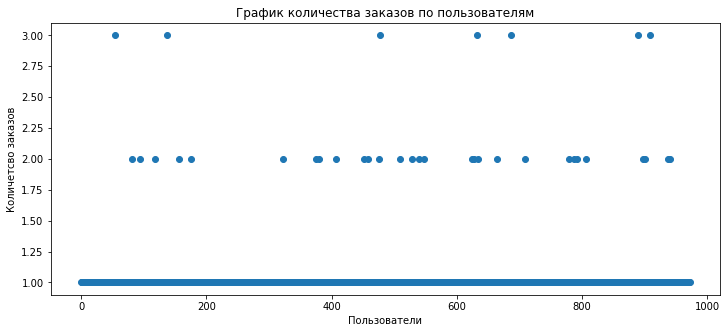

In [20]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['userId', 'orders']



plt.figure(figsize=(12,5))

plt.title('График количества заказов по пользователям')
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.xlabel('Пользователи')
plt.ylabel('Количетсво заказов')
plt.scatter(x_values, ordersByUsers['orders']) 

print('95-й и 99-й перцентили количества заказов на пользователя:',np.percentile(ordersByUsers['orders'], [ 95, 99]))

**Выводы**

Исходя из графика и расцета перцентиля, делаем вывод, что большинство клиентов совершают одну покупку, есть несколько значений в виде 2 покупок и 3 покупок.

Будем считать аномальным значение все больше 1.

# 2.7 График стоимостей заказов и 95-й и 99-й перцентили стоимости заказов.

95-й и 99-й перцентили стоимости заказов: [26785. 53904.]


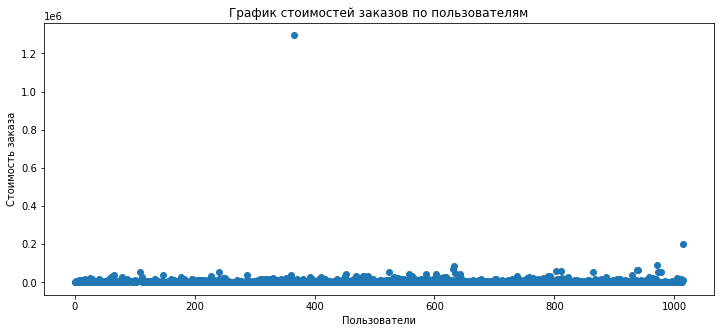

In [21]:
plt.figure(figsize=(12,5))

plt.title('График стоимостей заказов по пользователям')
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.scatter(x_values, orders['revenue']) 

print('95-й и 99-й перцентили стоимости заказов:',np.percentile(orders['revenue'], [95, 99]))


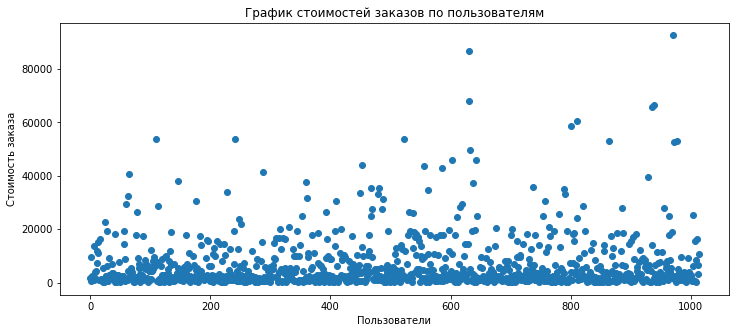

In [22]:
not_abnormal_orders = orders[orders['revenue']<=195000]['revenue']
xn_values = pd.Series(range(0,len(not_abnormal_orders)))

plt.figure(figsize=(12,5))

plt.title('График стоимостей заказов по пользователям')
plt.xlabel('Пользователи')
plt.ylabel('Стоимость заказа')
plt.scatter(xn_values, not_abnormal_orders);

**Выводы**

Из графика наблюдаем один аномально большой заказ, но если убрать его то видно, что большая масса находится от 20 000, по перцентилю выяснили, что аномалдьные значениями являются суммы заказов больше 26 785.

# 2.9 Статистическая значимость различий  в среднем количестве заказов на посетителя между группами по «сырым» данным.

**Для проверки гипотезы будем использовать критерий Уилкоксона-Манна-Уитни, так как в наших значениях есть выбросы , а так же даёт возможность делать вывод о различии или его отсутствии для любого заданного уровня значимости.**

**Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.**

**Для alpha возьмем значение равное 0,05**

**Сформулируем гипотезы.**
 - Нулевая: различий в среднем количестве заказов на посетителя между группами нет. 
 - Альтернативная: различия в количестве заказов на посетителя между группами есть.

In [23]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B'][ 'visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:',"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Отношение среднего кол-во заказов на посетителя "B" к "А": ',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


p-value: 0.011
Отношение среднего кол-во заказов на посетителя "B" к "А":  0.160


**Выводы**

p-value оказлось меньше 0,05 это означает то , что нулевую гипотезу о том, что статистически значимых различий в среднем кол-во заказов на посетителя между группами нет ,отвергаем.
Так же видно что группа В в выигрыше над А на 16%.

Из всего это делаем вывод что по «сырым» данным различия в среднем кол-во заказов на посетителя групп A и B присутсвуют.

# 2.10 Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

**Сформулируем гипотезы.**

 - Нулевая гипотеза: различий в среднем чеке между группами нет. 
 - Альтернативная гипотеза: различия в среднем чеке между группами есть. 
  

In [24]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Отношение среднего чека "B" к "А": ','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p-value: 0.829
Отношение среднего чека "B" к "А":  0.287


**Вывод**

По "сырым" данным p-value больше 0.05 значит нет причин отвергать нулевую гипотезу и различий между группами нет , но так же видно что группа В опять в выиграше по среднему чеку над группой А на 28%.

In [25]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(ordersByUsers['orders'], 95)]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], 95)]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print('Первые пять строк из таблицы с ID аномальных клиентов: ')
print(abnormalUsers.head(5))
print('Количество аномальных клиентов : ',abnormalUsers.shape[0]) 

Первые пять строк из таблицы с ID аномальных клиентов: 
568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
dtype: int64
Количество аномальных клиентов :  86


In [26]:
print('Отношние аномальных клиентов к общему количеству:', round((abnormalUsers.shape[0]/len(orders['visitorId']))*100,2),'%')

Отношние аномальных клиентов к общему количеству: 8.46 %


# 2.11 Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

**Сформулируем гипотезы.**
 - Нулевая: различий в среднем количестве заказов на посетителя между группами нет. 
 - Альтернативная: различия в среднем среднем количестве заказов на посетителя между группами есть.

In [27]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'A']['visitors'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                visitors[visitors['group'] == 'B'][ 'visitors'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Отношение среднего кол-во заказов на посетителя "B" к "А": ''{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p-value: 0.016
Отношение среднего кол-во заказов на посетителя "B" к "А": 0.174


**Вывод**

По очищенным данным p-value меньше 0.05, отвергаем нулевую гипотезу, разница в среднем кол-во заказов на посетителя есть, и исходя из второго показателя группа В побеждает на 17%, что больше чем по сырым.

# 2.12 Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

**Сформулируем гипотезы.**

 - Нулевая гипотеза: различий в среднем чеке между группами нет. 
 - Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [28]:
print('p-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print('Отношение среднего чека "B" к "А":',
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p-value: 0.727
Отношение среднего чека "B" к "А": -0.034


**Вывод**

По очищенным данным p-value больше 0.05 это означает что нет смысла отвергать нулевую гипотезу, и можно сказать что различий в среднем чеке нет, но по очищенным данным видно, что группа В немного проиграет группе А на 3%.

# Часть 3. Вывод

В результате теста выяснилось что,различия по среднему количеству заказов на посетителя присутсвуют, и что у группы В оно выше на 16% по "сырым" данным и 17% по "очищенным".

Результаты теста по среднему чеку показали что по "сырым" данным различий между группами нет, но группа В побеждает на 28%, но после обработки аномальных заказов мы увидели, что разницы по среднему чеку по прежднему нет, но чек группы В просел и теперь проигрывает группе А на 3%.

Итоговый результат всего теста это его остановка и констатация победы группы В, так как по среднему количетсву заказов на посетителя группа В хорошо себя показывает по всем видам данных, а относительная разница среднего чека довольно мала.